In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
from numpy.linalg import solve

## Radius Coordination

In [60]:
k = 210
h = 50
phi = 0.17
FVF = 1
c = 5e-6
mu = 5
Re = np.sqrt(30*43560/np.pi)
Rw = 0.25
alpha_lg = np.power((Re/Rw),(1/4))

In [78]:
R1 = alpha_lg * np.log(alpha_lg) / (alpha_lg-1) * Rw
R2 = R1*alpha_lg**1
R3 = R1*alpha_lg**2
R4 = R1*alpha_lg**3
Vb_func = lambda ri : (alpha_lg**2 - 1)**2 / (alpha_lg**2 * np.log(alpha_lg**2))*2*np.pi*h*(ri**2)

In [82]:
Vb1 = Vb_func(R1)
Vb2 = Vb_func(R2)
Vb3 = Vb_func(R3)
Vb4 = Vb_func(R4)

In [108]:
T

7.568161185832769

In [121]:
G = 2*3.14*0.001127*k*h/np.log(alpha_lg)
T = G/mu/FVF
RHS1 = Vb1*phi*c/(FVF*5.6145)
RHS2 = Vb2*phi*c/(FVF*5.6145)
RHS3 = Vb3*phi*c/(FVF*5.6145)
RHS4 = Vb4*phi*c/(FVF*5.6145)

pi = 3500
all_p = np.zeros([100, 4])
all_p[0] = pi
for t in range(1, 100):
    A = np.array([[T+RHS1, -T, 0, 0],
                  [-T, 2*T+RHS2, -T, 0],
                  [0, -T, 2*T+RHS3, -T],
                  [0, 0, -T, T+RHS4]
                ])
    b = np.array([RHS1*all_p[t-1][0]-1500, RHS2*all_p[t-1][1], RHS3*all_p[t-1][2], RHS4*all_p[t-1][3]])
    all_p[t] = solve(A, b)

In [113]:
t = 5

(RHS1*(all_p[t,0]-all_p[t-1,0]) + RHS2*(all_p[t,1]-all_p[t-1,1]) + RHS3*(all_p[t,2]-all_p[t-1,2])+ RHS4*(all_p[t,3]-all_p[t-1,3]))/1500

-1.0000000000000098

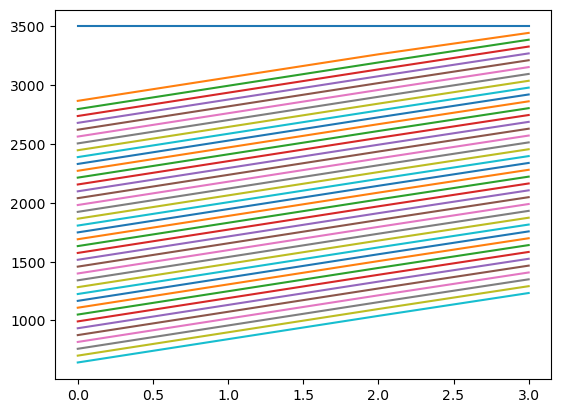

In [124]:
for i in range(40):
    plt.plot(all_p[i])

## 1D implicit and explicit

In [19]:
ndx = 4
dx = 400
dy = 900
h = 25
# Static rock properties
phi = 0.27
kx = 70
ky = 70
Vb = dx*dy*h
cp = 0
# fluid properties
mu = 1.5
rho = 62.4
FVF = 1
betha_c = 0.001127
cf = 0
alpha_c = 5.614583

In [4]:
# delta time (timestep)
dt = 0.001
# Number of time steps
ndt = 500
# Length
L = 1200
# Number of grids == number of nodes-1
ndx = 3
# boundary conditions pressure (numpy array with a length of 2)
bc_pressure = np.array([3750, 1250])


### Explicit

In [5]:
# Function to solve pressure equation for 1D
def pressure_equation_explicit(bc_pressure, dt, ndt, L, ndx):
    dx = L/ndx
    pressure = np.zeros(shape=[ndx+1, ndt], dtype=np.float64)
    pressure[0,:] = bc_pressure[0].copy()
    pressure[-1,:] = bc_pressure[1].copy()
    dt_dx2 = dt/(dx*dx)
    for t in range(ndt-1):
        pressure[1:-1, t+1] = pressure[1:-1, t] + dt_dx2*(pressure[:-2, t] + pressure[2:, t] - 2*pressure[1:-1, t])
    return pressure

### Implicit

In [6]:
def pressure_equation_implicit(bc_pressure, dt, ndt, L, ndx=10):
    pressure = np.zeros(shape=[ndx+1, ndt])
    pressure[0,:] = bc_pressure[0].copy()
    pressure[-1,:] = bc_pressure[1].copy()
    for time in np.arange(ndt-1):
        A = np.zeros([ndx-1, ndx-1])
        b = np.zeros(ndx-1) # Unnecessary; dimensions defined by pressure length - 2
        dx = L/ndx
        a = -(2+dx*dx/dt)
        for i in range(ndx-2):
            A[i+1, i] = 1
            A[i, i+1] = 1
            A[i, i] = a
            if i == ndx-3:
                A[i+1,i+1] = a
        b = -(dx*dx/dt)*pressure[1:-1, time]
        b[0] = -(dx*dx/dt)*pressure[1, time] - pressure[0, time]
        b[-1] = -(dx*dx/dt)*pressure[-2, time] - pressure[-1, time]
        pressure[1:-1, time+1] = np.linalg.solve(A, b)
    return pressure

In [9]:
ndx = 3
dt = 0.001
ndt = 100
p_ex = pressure_equation_explicit(bc_pressure, dt, ndt, L, ndx=ndx)

p_im = pressure_equation_implicit(bc_pressure, dt, ndt, L, ndx=ndx)

In [16]:
r2_time = np.array([r2_score(p_im[:, t], p_ex[:, t]) for t in np.arange(ndt)])

Text(0.5, 1.0, 'Time : 0.05 s')

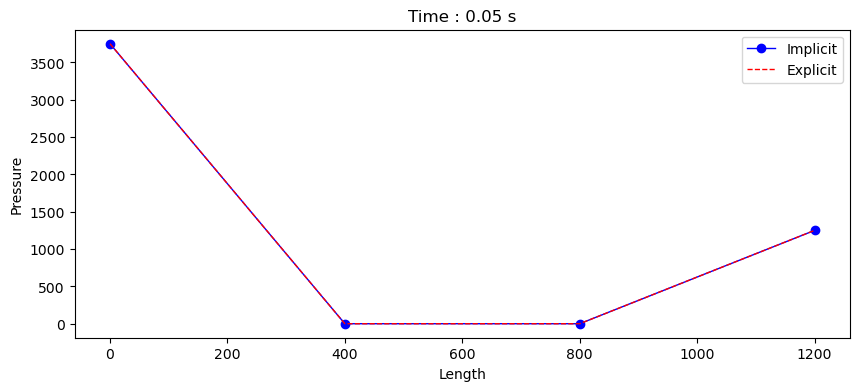

In [10]:
timestep = 50
plt.figure(figsize=(10,4))
plt.ylabel('Pressure')
plt.xlabel('Length')
plt.plot(np.linspace(0, L, ndx+1), p_im[:, timestep], 'bo-', linewidth=1)
plt.plot(np.linspace(0, L, ndx+1), p_ex[:, timestep], 'r--', linewidth=1)
plt.legend(['Implicit', 'Explicit'])
plt.title(f"Time : {timestep*dt} s")

## 1D-Incomressible

In [131]:
ndx = 4
dx = 300
dy = 600
h = 30
# Static rock properties
phi = 0.27
kx = 180
# fluid properties
mu = 2.4
FVF = 1
betha_c = 0.001127
rho = 45
landa = 0.21584*1e-3*rho*32.174

In [108]:
# delta time (timestep)
dt = 0.001
# Number of time steps
ndt = 500
# Number of grids == number of nodes-1
ndx = 4
# Length
L = ndx*dx


In [133]:
T = betha_c*(dy*h)*kx/(mu*FVF*dx)

In [138]:
T*landa*(z[2]-z[1])

-96.32668821097725

In [140]:
b

array([-4.16326688e+02,  7.10542736e-13,  8.87511441e-01,  9.44248768e+01])

In [139]:
p = np.zeros([ndx, ndt+1])
p[:, 0] = 1200
req = dy*dy + h*h
rw = 0.25
pwf = 1200
Gw = 2*3.14*betha_c*kx*h/np.log(req/rw)
z = [3562.73, 3532.34, 3471.56, 3410.78, 3350.56, 3319.62]

for t in range(1):
    well_coef = Gw/(FVF*mu)
    qw = (p[2, t]-pwf)*
    A = np.array([[-T, T, 0, 0],
                  [T, -2*T, T, 0],
                  [0, T, -2*T, T],
                  [0, 0, T, -T]])
    b = np.array([-320+T*landa*(z[2]-z[1]),
                  T*landa*(z[1]-z[2])+T*landa*(z[3]-z[2]),
                  qw+T*landa*(z[2]-z[3])+T*landa*(z[4]-z[3]),
                  -T*0.2+T*landa*(z[3]-z[4])])
    p[:, t+1] = solve(A, b)

LinAlgError: Singular matrix

Text(0, 0.5, 'Pressure (psi)')

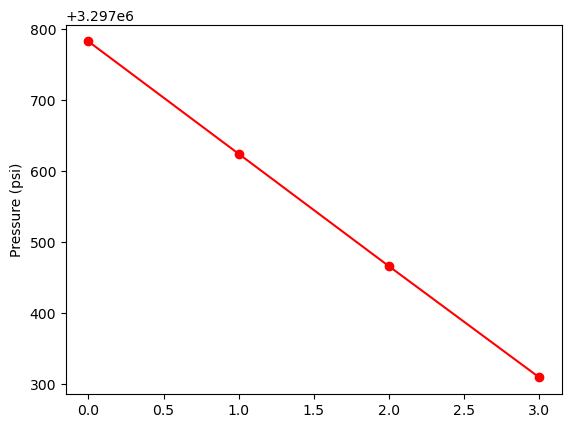

In [116]:
# for i in range(100,ndt):
plt.plot(p[:, 1], 'ro-')
plt.ylabel('Pressure (psi)')

In [50]:
p[:, -1]

array([2408.74213177, 2217.48426353, 2026.2263953 , 2026.0263953 ])

In [49]:
req

810625

In [67]:
qw

565.220820932864

In [68]:
T*(2600-p[0,-1]) - qw - 0.2*T

-4.454214774796128e-13